In [1]:
import xarray as xr
from thesis_toolbox.cluster_tools import get_dust_trajectories 
import numpy as np
import pandas as pd
from fpcluster.plot_trajectories import dist_from_center, get_distance_circles
from thesis_toolbox.composites.create_composites import detrend_timeseries, select_years_to_composite
from fpcluster.adaptive_kmeans import center_of_mass_trajectory
import matplotlib.pyplot as plt
import fpcluster as fc
from matplotlib import collections, colors, transforms
import cartopy.crs as ccrs
from dust import map_terrain_china, map_china
from thesis_toolbox.utils import get_locations_CLP
from thesis_toolbox.plot.trajectory_plotting import plot_center_spread_trajectory
import matplotlib as mpl
from thesis_toolbox.plot.tools import add_letter
def get_keys(locs,kind,psize):
    keys_drydep = [f'{l} {kind} {psize}' for l in locs]
    return keys_drydep
%matplotlib inline

In [2]:
if 'snakemake' in globals():
    to_file = True
    path='./'
else:
    path = '../../'
    to_file= False

## Dust loading trajectories during weak and strong deposition years SACOL

In [3]:
def strong_and_weak_transport_trajectories(df,data_path, kind,psize,locs=None,c=4):
    if locs == None:
        locs = get_locations_CLP().index
    dsets = {}
    for loc in locs:
        dd_ts = detrend_timeseries(df[f'{loc} {kind} {psize}'])
        wd_years, sd_years = select_years_to_composite(dd_ts,c=4)
        ds = xr.open_dataset(f'{data_path}/dust_loading_traj_{kind}_{psize}_{loc}_1999-2019.nc')
        w_year_trajecs=[]
        s_year_trajecs=[]
        for w_year,s_year in zip(wd_years,sd_years):
            w_year = str(w_year)
            s_year = str(s_year)
            w_year_trajecs.append(ds.sel(time=w_year))
            s_year_trajecs.append(ds.sel(time=s_year))
            
        w_years = xr.concat(w_year_trajecs,dim='time')
        s_years = xr.concat(s_year_trajecs,dim='time')
        
        dsets[f'wd_{loc}_{kind}_{psize}'] = w_years
        dsets[f'sd_{loc}_{kind}_{psize}'] = s_years
        
    return dsets

    

In [4]:

data_table=pd.read_csv(path+'results/timeseries_table.csv',
                      index_col=0)


In [5]:
def weighted_std(ct_dist,mean, weight=None):
    variance = np.zeros((mean.shape[0]))
    for i in range(mean.shape[0]):
        variance[i] = np.average((ct_dist[i,:]-mean[i])**2, weights=weight)
    ct_dist = np.sqrt(variance)
    return ct_dist

In [6]:
def plot_height_difference(ds_strong, ds_weak,loc,ax,kind,weighted=True,btime_limit=72,
                          ymin=-500,ymax=500):
    ds_strong = ds_strong.sel(btime=slice(0,-btime_limit*3600))
    ds_weak = ds_weak.sel(btime=slice(0,-btime_limit*3600))
    if weighted:
        weights_wd = ds_weak[kind]
        weights_sd = ds_strong[kind]
    else:
        weights_sd = None
        weights_wd = None
    height_strong = ds_strong.height - ds_strong.mean_topo
    height_weak = ds_weak.height - ds_weak.mean_topo
    height_weak = np.average(height_weak,axis=1, weights=weights_wd)
    height_strong = np.average(height_strong,axis=1, weights=weights_sd)
    time = np.abs(ds_strong.btime/3600)
    ax.set_xticks(np.arange(0,btime_limit+12,12))
    
    
    delta_height = height_strong - height_weak
    ax.plot(time , delta_height, label=loc)
    ax.set_ylim(ymin,ymax)
    

In [7]:
def plot_weak_strong_trajectories(dset_dict,kind,psize,locs=None, figsize=(8.3, 11.7),
                                  vmin=0,vmax=5000, alpha_spread=.1, ymin=-500, ymax=500):
    fig,ax = plt.subplots(nrows=4,ncols=2,figsize=figsize, subplot_kw=dict(projection=ccrs.PlateCarree()))
    axes = ax.ravel()
    axes[-1] = fig.add_subplot(4,2,8)
    if locs == None:
        locs=get_locations_CLP()
    for i,loc in enumerate(locs):
        ds_wd = dset_dict[f'wd_{loc}_{kind}_{psize}']
        ds_sd = dset_dict[f'sd_{loc}_{kind}_{psize}']

        plot_center_spread_trajectory(ds_wd, ax=axes[i],  add_trajectory_marks=True, weights=ds_wd[kind],
                                      mapping='plain',plot_spread=True,alpha_spread=alpha_spread, color='blue',color_markers='#1A39FF',
                                      trajectory_marker='o',vmin=vmin,vmax=vmax,mark_size=2.5)
        plot_center_spread_trajectory(ds_sd, ax=axes[i], color='red', add_trajectory_marks=True,weights=ds_sd[kind],
                                      mapping='plain',plot_spread=True,alpha_spread=alpha_spread,vmin=vmin,vmax=vmax,mark_size=2.5)
        plot_height_difference(ds_sd,ds_wd,locs[i],axes[-1],kind, ymin=ymin, ymax=ymax)

        axes[i].tick_params(axis="y", which='both',right=True, left=True, labelleft=True, labelright=False)
        if locs[i] == 'BADOE':
            loc_name='BAODE'
        else:
            loc_name=locs[i]
        axes[i].set_title(loc_name)
        if i in (1,3,5):
            axes[i].tick_params(axis="y", which='both',right=True, left=True, labelleft=False, labelright=True)
    
    
    
    axes[-1].set_xlabel('Time backwards along trajectory [hours]')
    axes[-1].set_ylabel('$\Delta h$ [m] \n strong - weak years')
    axes[-1].tick_params(axis="y", which='both',right=True, left=False, labelleft=False, labelright=True)
    axes[-1].yaxis.set_label_position("right")
    h,l = axes[-1].get_legend_handles_labels() 
    if l[1]=='BADOE':
        l[1] = 'BAODE'
    
    cax = fig.add_axes([0.96, 0.4, 0.04,0.45])
    
    fig.legend(h,l, bbox_to_anchor=(0.5, 0.05), loc='center',ncol=4)
    fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin,vmax)), cax=cax,
            label='Height above ground [m]')
    fig.subplots_adjust(hspace=0.1, wspace=0.05)
    add_letter(axes, y=0.85)

  File "/tmp/xpython_23851/770654992.py", line 20
    if locs[i] == 'BADOE'
                         ^
SyntaxError: invalid syntax



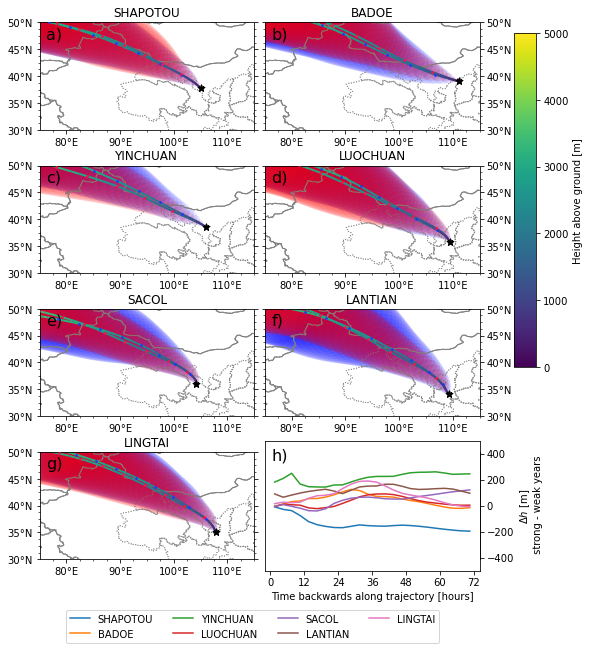

In [12]:
dsets_dict = strong_and_weak_transport_trajectories(data_table, path+'results/model_results/trajectories', 
                                                    kind='drydep',psize='2micron')
locs = ['SHAPOTOU','BADOE','YINCHUAN','LUOCHUAN','SACOL','LANTIAN','LINGTAI']
plot_weak_strong_trajectories(dsets_dict, 'drydep','2micron',locs, figsize=(8.3*0.95, 11.7*0.88),alpha_spread=0.1)
if to_file:
    plt.savefig(snakemake.output.weak_strong_clay_drydep, bbox_inches='tight')

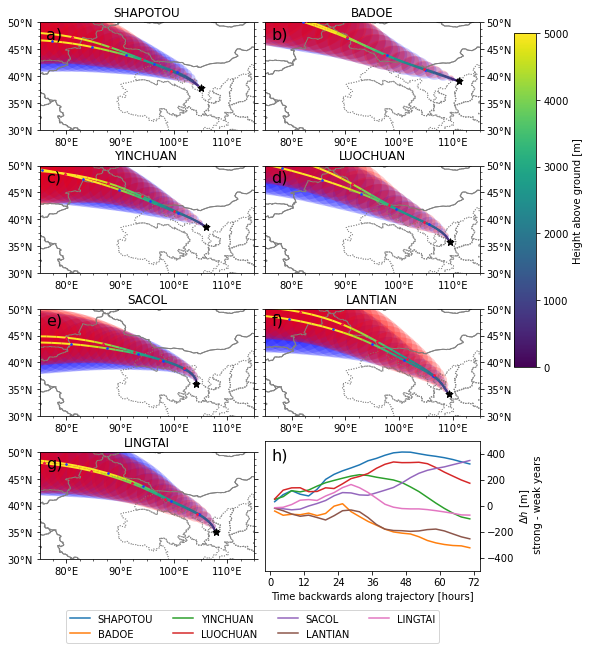

In [9]:
dsets_dict = strong_and_weak_transport_trajectories(data_table, path+'results/model_results/trajectories', 
                                                    kind='drydep',psize='20micron')
locs = ['SHAPOTOU','BADOE','YINCHUAN','LUOCHUAN','SACOL','LANTIAN','LINGTAI']
plot_weak_strong_trajectories(dsets_dict, 'drydep','20micron',locs, figsize=(8.3*0.95, 11.7*0.88),alpha_spread=0.2)
if to_file:
    plt.savefig(snakemake.output.weak_strong_silt_drydep, bbox_inches='tight')

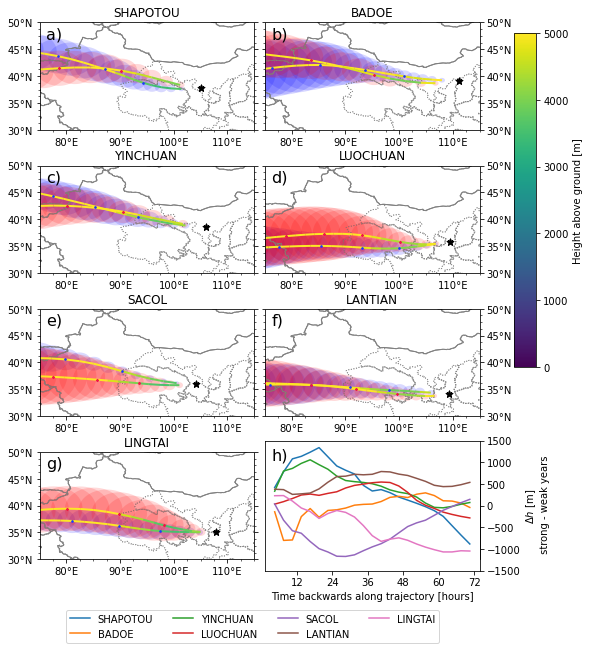

In [10]:
dsets_dict = strong_and_weak_transport_trajectories(data_table, path+'results/model_results/trajectories', 
                                                    kind='wetdep',psize='20micron')
locs = ['SHAPOTOU','BADOE','YINCHUAN','LUOCHUAN','SACOL','LANTIAN','LINGTAI']
plot_weak_strong_trajectories(dsets_dict, 'wetdep','20micron',locs, 
                              figsize=(8.3*0.95, 11.7*0.88),alpha_spread=0.15, ymin=-1500, ymax=1500)
if to_file:
    plt.savefig(snakemake.output.weak_strong_silt_wetdep, bbox_inches='tight')

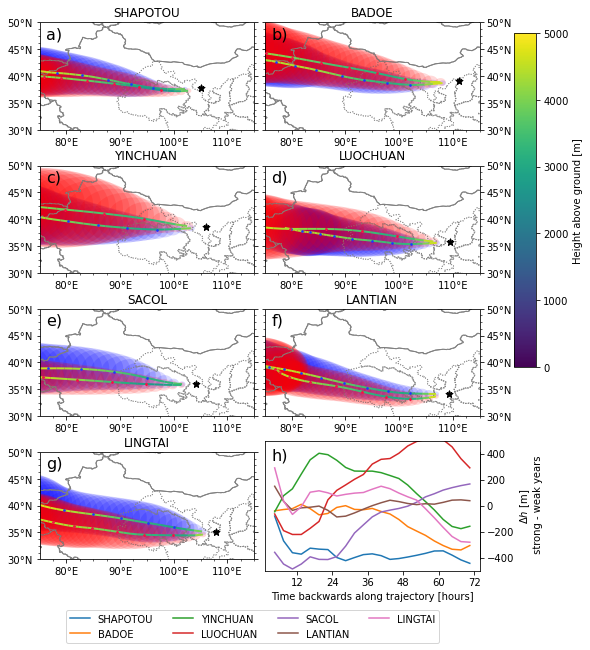

In [11]:
dsets_dict = strong_and_weak_transport_trajectories(data_table, path+'results/model_results/trajectories', 
                                                    kind='wetdep',psize='2micron')
locs = ['SHAPOTOU','BADOE','YINCHUAN','LUOCHUAN','SACOL','LANTIAN','LINGTAI']
plot_weak_strong_trajectories(dsets_dict, 'wetdep','2micron',locs, figsize=(8.3*0.95, 11.7*0.88),alpha_spread=0.15)
if to_file:
    plt.savefig(snakemake.output.weak_strong_clay_wetdep, bbox_inches='tight')